In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

In [6]:
from util import show, plot_images, plot_tensors

In [7]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


EPOCHS = 2
BATCH_SIZE = 20
LEARNING_RATE = 0.003
TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(64),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    
    ])
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(root=GT_DATA_PATH, transform=TRANSFORM_IMG)


In [8]:
dataset1 = train_data
dataset2 = gt_data


class gtmatch(Dataset):
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        
    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y= self.dataset2[int(index/batch_size % batch_size)][0]
        return x, y
    
    def __len__(self):
        return len(self.dataset1)

newdataset = gtmatch(dataset1, dataset2, 50)

In [9]:
batch_size=50
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.05

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img



In [13]:
#noisy_data_train = SyntheticNoiseDataset(train_data, 'train')

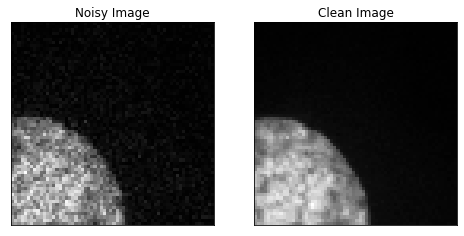

In [14]:
noisy,clean=newdataset[61]
plot_tensors([noisy[0], clean[0]], ['Noisy Image', 'Clean Image'])

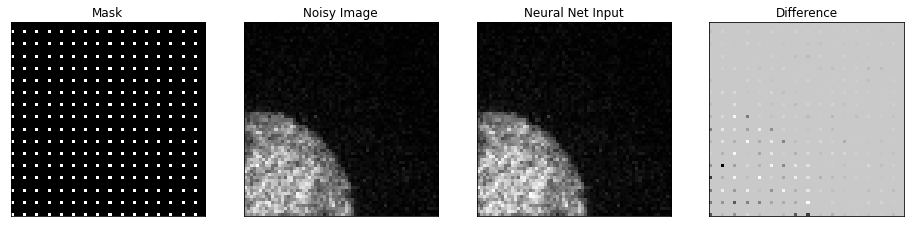

In [15]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')
net_input, mask = masker.mask(noisy.unsqueeze(0), 3)
plot_tensors([mask, noisy[0], net_input[0], net_input[0] - noisy[0]],
            ["Mask", "Noisy Image", "Neural Net Input", "Difference"])

In [16]:
from models.babyunet import BabyUnet

model = BabyUnet()

In [17]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging 
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [18]:
n=800
t=1000
split=torch.utils.data.random_split(newdataset, [n,t-n]);
train=split[0];
test=split[1];

In [ ]:
from mask import Masker

data_loader = DataLoader(train, batch_size=50, shuffle=True)

#noisy, clean = noisy_data_train[0];
#net_input, mask = masker.mask(noisy.unsqueeze(0), 0);

losses = []
val_losses = []
best_images = []
best_val_loss = 1

for i, batch in enumerate(data_loader):
    noisy_images, clean_images = batch
    
    model.train()
 
    net_input, mask = masker.mask(noisy_images, i)
    net_output = model(net_input)
    
    loss = loss_function(net_output*mask, noisy_images*mask)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()

    losses.append(loss.item())
    model.eval()
    

    net_input, mask = masker.mask(noisy_images, masker.n_masks - 1)
    net_output = model(net_input)

    val_loss = loss_function(net_output*mask, noisy_images*mask)

    val_losses.append(val_loss.item())



    print("Loss (", i, "): \t", round(loss.item(), 4))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = np.clip(model(noisy_images).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        clean=np.clip(clean_images.detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        best_psnr = compare_psnr(denoised, clean)
        best_images.append(denoised)
        print("\tModel PSNR: ", np.round(best_psnr, 2))



Loss ( 0 ): 	 0.0303


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  16.06
Loss ( 1 ): 	 0.0688
	Model PSNR:  18.36
Loss ( 2 ): 	 0.0507


In [ ]:
test_data_loader = DataLoader(test,
                                              batch_size=50,
                                              shuffle=True,
                                              num_workers=3)
i, test_batch = next(enumerate(test_data_loader))
noisy, clean = test_batch

In [ ]:
simple_output = model(noisy)
invariant_output = masker.infer_full_image(noisy, model)

In [ ]:
idx = 19
plot_tensors([clean[idx], noisy[idx], simple_output[idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [ ]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output).item(), 3))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 3))